In [1]:
#UNBEDINGT VORHER AUSFÜHREN!: pip install pyamaze
#Jede Zelle hier muss 1 mal der Reihe nach ausgeführt werden, nachher kann man die Zellen zum Testen und Trainieren des QAgenten beliebig oft laufen lassen
#Wegen einem Bug im Modul Pymaze, muss man den Kernel jedes mal wenn man die Animation sehen will neu starten und muss jede Zelle neu ausführen
#In diesem Abschnitt wird das Labyrinth welches man mit dem AI testen will Generiert
from pyamaze import maze, agent, COLOR
m=maze(10,10) #Hier kann man die Anzahl Zeilen und Spalten im Labyrinth festlegen
zielx, ziely = 1, 1 #Hier kann man die Zielposition des Labyrinths festlegen
m.CreateMaze(zielx,ziely,theme=COLOR.light,loopPercent=50) #hier wurde der hintergrund weiss gemacht und die Zielposition übernommen
#mit loopPercent kann man definieren wie viel vom Labyrinth zusammenhängend ist, mit dem Wert 50 ist 50% zusammenhängend
a=agent(m, 9, 9, footprints=True,) #definiert einen Agenten mit einem Pfad, mit den Zahlen kann man die Startposition des Labyrinths festlegen
start_pos=a.position #Die Startposition des Labyrinths ist bei der Position des Agenten
ziel_pos=(zielx, ziely) #Die Zielposition ist bei dem Pymaze Modul üblicherweise bei (1, 1), man kann es bei CreateMaze jedoch ändern
maze_layout=m.maze_map #Der Layout des Labyrinths wird der hier generierten Maze-Map gleichgestellt
zeilen=m.rows #m.rows/m.cols sind Anzahl Zeilen und Spalten im Pymaze Labyrinth
spalten=m.cols
print('test') #Ausführungstest

test


In [2]:
#Dieser Code definiert alle Variabeln, Regeln und Formeln die der Aagent hat/braucht
import numpy as np #Numpy wird hier vor allem gebraucht um den Q-Table zu kreieren und zu aktualisiseren

aktionen=[(-1,0), (0,1), (1,0), (0,-1)] #die 4 möglichen Bewegungen

class Maze: #Diese Klasse dient Hauptsächlich für die Ordnung des Programms
    def __init__(self, maze_layout, start_pos, ziel_pos): #Initialisiert das Maze Objekt mit ihren Instanz-Variabeln
        self.start_pos = start_pos
        self.ziel_pos = ziel_pos
        self.maze_layout = maze_layout
        
    def zu(self, position, richtung): #Definiert die Funktion zu, welche prüft ob der Weg für den Agenten offen oder zu ist
        return self.maze_layout.get(position, {}).get(richtung, 0) == 0 #sie benutzt den vorher definierten maze_Layout und gibt True zurück, wenn
                                                                        #der Wert für die gegebene richtung in der position im maze_layout gleich 0 ist.
maze_zu = Maze(maze_layout, start_pos, ziel_pos) #Maze-Objekt wird erstellt, die Funktion 'zu' kann vom Programm auf diesem Objekt aufgerufen werden

class QAgent: #Klasse, initialisiert den QAgent mit verschiedenen Parametern                   DIE EPISODEN VERSTELLEN NICHT VERGESSEN, WENN UNTEN VERSTELLT WURDE!
    def __init__(self, maze_layout, gamma=0.9, alpha=0.1, epsilon_start=1, epsilon_end=0.01, episoden=100): #Alle Parameter ausser Episoden können im Bereich 0 bis 1 geändert werden
        self.q_table = np.zeros((spalten+1, zeilen+1, 4)) #Kreiert mithilfe von Numpy eine Q-Tabelle für jedes Feld für je 4 Richtungen, am Anfang sind die Werte alle 0
        self.gamma = gamma #Verminderungsrate, Agent interessiert sich für Langzeitfolgen
        self.alpha = alpha #Lernfähigkeit, Agent passt seine alte Zelle mit dem Gewicht Alpha teilweise an
        self.epsilon_start = epsilon_start #Wert für die Erkundungsrate am anfang (hoch)
        self.epsilon_end = epsilon_end #Wert für die Erkundungsrate am Schluss (tief)
        self.episoden = episoden #Anzahl Durchläufe, hier provisorisch mit 1 versehen
        
    def hol_epsilon(self, aktuelle_episode): #Standartformel, die ausrechnet wie gross Epsilon bei einer Episode ist
        epsilon = self.epsilon_start * (self.epsilon_end / self.epsilon_start) ** (aktuelle_episode / self.episoden)
        return epsilon
    
    def hol_aktion(self, zustand, aktuelle_episode):
        epsilon = self.hol_epsilon(aktuelle_episode) #ruft das Epsilon für die aktuelle Episode ab
        if np.random.rand() < epsilon: #Wenn die Zufallszahl kleiner als Epsilon ist, wird eine der 4 Aktionen zufällig ausgeführt
            return np.random.randint(4)
        else:
            return np.argmax(self.q_table[zustand]) #sonst wird die Aktion die den höchsten Q-Wert bringt ausgeführt
        
    def update_q_table(self, zustand, aktion, zustand_1, belohnung): #Funktion für die aktualisierung der Q-Tabelle für ein Zustands-Aktions-Paar
        aktion_1_max = np.argmax(self.q_table[zustand_1]) #findet die Aktion mit dem höchsten Q-Wert im nächsten Zustand
        q_wert = self.q_table[zustand][aktion] #holt den Q-Wert für die aktuelle Aktion in diesem Zustand
        q_wert_neu = q_wert + self.alpha * (belohnung + self.gamma * self.q_table[zustand_1][aktion_1_max] - q_wert) #Formel für die Berechnung des Q-Werts
        self.q_table[zustand][aktion] = q_wert_neu #aktualisiert den Q-Wert für das aktuelle Zustands-Aktions-Paar

#beliebig verstellbare Belohnungen
ziel_belohnung = 1000 #Belohnung für das erreichen des Ziels
wand_belohnung = -10 #Bestrafung für das laufen in eine Wand
schritt_belohnung = -1 #Bestrafung für das nehmen eines Schritts

def episode_end(qagent, maze_layout, aktuelle_episode, train=True): #Funktion für die simulation einer Episode
    aktueller_zustand = start_pos #der aktuelle Zustand des Agenten wird auf seine Startposition gesetzt
    fertig = False #die Schleife wird damit nachher in Gang gesetzt
    episode_belohnung = 0 #Die Werte für die Belohnung und die Schritte dieser Episode werden auf 0 gesetzt
    episode_schritt = 0
    path = [aktueller_zustand] #eine Liste path wird kreiert mit dem aktuelles Zustand

    while not fertig:
        aktion = qagent.hol_aktion(aktueller_zustand, aktuelle_episode) #holt entweder eine Zufallsaktion oder die mit dem höchsten Q-Wert

        zustand_1 = (aktueller_zustand[0] + aktionen[aktion][0], aktueller_zustand[1] + aktionen[aktion][1]) #der nächste Zustand wird darauf basiert ausgerechnet

        if zustand_1[0] < 1 or zustand_1[0] > spalten or zustand_1[1] < 1 or zustand_1[1] > zeilen: #Check ob der Agent ausserhalb vom Labyrinth will
            belohnung = wand_belohnung #bestrafung
            zustand_1 = aktueller_zustand #Agent wird wieder zurückgesetzt
            
        #Mit der zu Funktion wird geprüft, ob der Agent versucht durch eine Wand zu gehen (für alle Richtungen)
        #Falls dies der Fall ist, wird er Bestraft und zurückgestellt
        elif aktion == 0 and maze_zu.zu(zustand_1, 'S') == 1: 
            belohnung = wand_belohnung
            zustand_1 = aktueller_zustand
        elif aktion == 1 and maze_zu.zu(zustand_1, 'W') == 1:
            belohnung = wand_belohnung
            zustand_1 = aktueller_zustand
        elif aktion == 2 and maze_zu.zu(zustand_1, 'N') == 1:
            belohnung = wand_belohnung
            zustand_1 = aktueller_zustand
        elif aktion == 3 and maze_zu.zu(zustand_1, 'E') == 1:
            belohnung = wand_belohnung
            zustand_1 = aktueller_zustand
        elif zustand_1 == ziel_pos: #für wenn der Agent ins Ziel kommt
            path.append(aktueller_zustand) #die Positionen werden in die Liste eingetragen
            path.append(ziel_pos)
            belohnung = ziel_belohnung #dem Agent wird die Ziel Belohnung ausgeteilt
            fertig = True #die Schleife wird beendet
        else: #sonst würde es heissen, dass der Agent normale Schritte nimmt, der Agent wird bestraft und seine Positionen in die Liste Path eingetragen
            path.append(aktueller_zustand)
            belohnung = schritt_belohnung
        #Für die Berechnung der kumulativen Belohnung und Schritte
        episode_belohnung += belohnung
        episode_schritt += 1

        if train == True:
            #update_q_table Funktion wird aufgerufen um die Q-Tabelle für den Zustand zu aktualisieren
            qagent.update_q_table(aktueller_zustand, aktion, zustand_1, belohnung)

        aktueller_zustand = zustand_1

    return episode_belohnung, episode_schritt, path


print('test') #Ausführungstest

test


In [3]:
#die Funktion test_agent ruft die episode_end Funktion auf, welche einen Durchgang des Q-Learnings ausführt
def test_qagent(qagent, maze_layout, episoden=1):
    episode_belohnung, episode_schritt, path = episode_end(qagent, maze_layout, episoden, train=True)
    
    #Druckt die Liste path aus
    print("Weg:")
    for row, col in path:
        print(f"({row}, {col}), ", end='')
    print("Ziel!")
    
     #Wenn der spätere Test mit xy Episoden aufgerufen wird, animiert pymaze den Agent im Labyrinth
    if episoden==100: #DIE EPISODEN VERSTELLEN NICHT VERGESSEN, WENN UNTEN VERSTELLT WURDE!
        m.tracePath({a:path})
    #Schrittzahl und Endbelohnung werden ausgedruckt
    print("Schrittzahl:", episode_schritt)
    print("Endbelohnung:", episode_belohnung)
    
    return episode_schritt, episode_belohnung

qagent = QAgent(maze_layout)
test_qagent(qagent, maze_layout)

Weg:
(9, 9), (9, 9), (9, 8), (9, 9), (8, 9), (8, 8), (7, 8), (8, 8), (8, 9), (8, 8), (7, 8), (8, 8), (8, 7), (7, 7), (7, 6), (8, 6), (7, 6), (8, 6), (7, 6), (7, 7), (8, 7), (9, 7), (8, 7), (7, 7), (8, 7), (8, 8), (8, 7), (7, 7), (7, 6), (7, 7), (8, 7), (9, 7), (8, 7), (7, 7), (7, 6), (8, 6), (8, 5), (8, 6), (8, 5), (8, 6), (8, 5), (7, 5), (7, 4), (7, 5), (7, 4), (7, 5), (7, 4), (7, 3), (6, 3), (6, 2), (7, 2), (7, 1), (7, 2), (6, 2), (6, 3), (6, 2), (6, 3), (7, 3), (7, 4), (7, 5), (8, 5), (8, 6), (8, 5), (7, 5), (8, 5), (7, 5), (8, 5), (7, 5), (8, 5), (8, 4), (8, 5), (8, 4), (8, 5), (8, 6), (7, 6), (8, 6), (8, 5), (8, 6), (7, 6), (7, 7), (8, 7), (8, 8), (8, 9), (9, 9), (8, 9), (9, 9), (9, 8), (10, 8), (9, 8), (10, 8), (9, 8), (9, 9), (9, 8), (9, 9), (8, 9), (9, 9), (8, 9), (8, 8), (8, 7), (8, 8), (8, 7), (9, 7), (10, 7), (9, 7), (9, 6), (9, 7), (8, 7), (9, 7), (10, 7), (10, 6), (10, 5), (10, 6), (10, 7), (10, 8), (9, 8), (9, 9), (8, 9), (9, 9), (9, 8), (9, 9), (8, 9), (8, 8), (7, 8), (8

(2870, -12543)

Durchschnittliche Belohnung: 599.22
Durchschnittliche Schrittzahl: 130.88


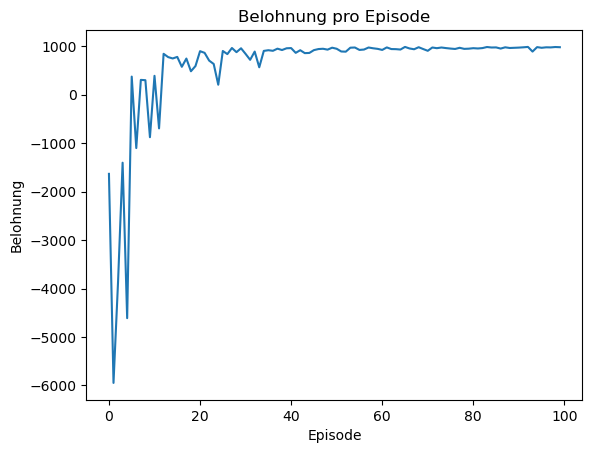

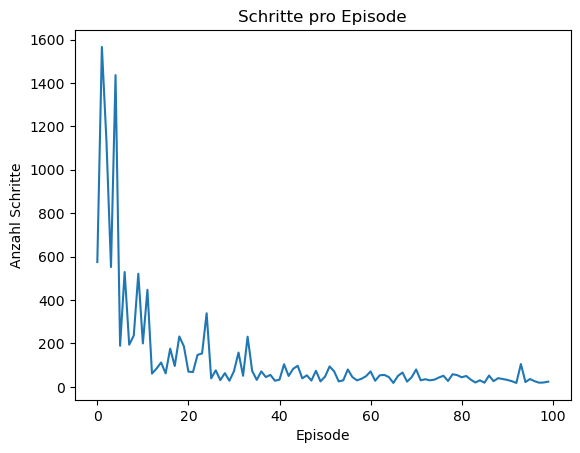

In [4]:
#dieses Modul wird hier hauptsächlicht zur Verbildlichung der Graphen gebraucht
import matplotlib.pyplot as plt
#Funktion, die den Agenten für xy Episoden trainiert
def train_qagent(qagent, maze_layout, episoden=100):#DIE EPISODEN VERSTELLEN NICHT VERGESSEN, WENN UNTEN VERSTELLT WURDE!
    #Liste aller zusammenadierten Belohnungen einer Episode
    episode_belohnung_kum = []
    #Liste aller zusammenadierten Schritte einer Episode
    episode_schritt_kum = []

    #Diese Schleife ruft die Anzahl Episoden mal die episode_end Funktion auf, nach jedem durchlauf werden die 2 Listen aktualisiert
    for episode in range(episoden):
        episode_belohnung, episode_schritt, path = episode_end(qagent, maze_layout, episode, train=True)

        episode_belohnung_kum.append(episode_belohnung)
        episode_schritt_kum.append(episode_schritt)
    
    # verbildlicht einen Graph der Liste der Belohnungen
    plt.figure(1)   
    plt.plot(episode_belohnung_kum)
    plt.title('Belohnung pro Episode')
    plt.xlabel('Episode')
    plt.ylabel('Belohnung')
    
    #verbildlicht einen Graph der Liste der Anzahl Schritte
    plt.figure(2)
    plt.plot(episode_schritt_kum)
    plt.title('Schritte pro Episode')
    plt.xlabel('Episode')
    plt.ylabel('Anzahl Schritte')

    #Rechnet die durchschnittliche Belohnung in den xy Episoden aus
    belohnung_durchschnitt = sum(episode_belohnung_kum) / len(episode_belohnung_kum)
    print(f"Durchschnittliche Belohnung: {belohnung_durchschnitt}")
    
    #Rechnet die durchschnittliche Schrittzahl in den xy Episoden aus
    schritt_durchschnitt = sum(episode_schritt_kum) / len(episode_schritt_kum)
    print(f"Durchschnittliche Schrittzahl: {schritt_durchschnitt}")
#zeigt die Graphen
plt.show()
train_qagent(qagent, maze_layout, episoden=100)#DIE EPISODEN VERSTELLEN NICHT VERGESSEN, WENN UNTEN VERSTELLT WURDE!

In [5]:
#testet den Agenten mit der episode_end Funktion nach dem Training
test_qagent(qagent, maze_layout, episoden=100) #Hier kann man die Episoden verstellen
#OBEN AUCH VERSTELLEN, FALLS HIER VERSTELLT WURDE!!
#Lässt das Pymaze modul den Weg 'path' animieren
m.run()

Weg:
(9, 9), (9, 9), (8, 9), (9, 9), (9, 8), (10, 8), (9, 8), (10, 8), (10, 9), (10, 10), (10, 9), (10, 8), (10, 9), (10, 10), (9, 10), (8, 10), (9, 10), (10, 10), (9, 10), (8, 10), (7, 10), (8, 10), (7, 10), (6, 10), (6, 9), (7, 9), (6, 9), (6, 10), (5, 10), (6, 10), (7, 10), (6, 10), (6, 9), (7, 9), (6, 9), (6, 10), (5, 10), (5, 9), (5, 8), (6, 8), (6, 7), (6, 8), (7, 8), (6, 8), (6, 7), (6, 6), (6, 7), (5, 7), (4, 7), (5, 7), (6, 7), (5, 7), (4, 7), (4, 6), (5, 6), (5, 5), (6, 5), (6, 4), (6, 3), (6, 2), (5, 2), (5, 1), (4, 1), (3, 1), (2, 1), (1, 1), Ziel!
Schrittzahl: 64
Endbelohnung: 937
